In [ ]:
pip install tensorflow-datasets


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Step-3 load the food -101 DataSet

In [ ]:

(ds_train, ds_test), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.MSGE3N_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.MSGE3N_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
#step4
print("Total Classes:", ds_info.features['label'].num_classes)
print("Sample Classes:", ds_info.features['label'].names[:10])

Total Classes: 101
Sample Classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [ ]:
# Step 5
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
    image = tf.cast(image, tf.float32) / 255.0            # Normalize pixels to [0, 1]
    return image, label

# Apply preprocessing to the datasets
ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


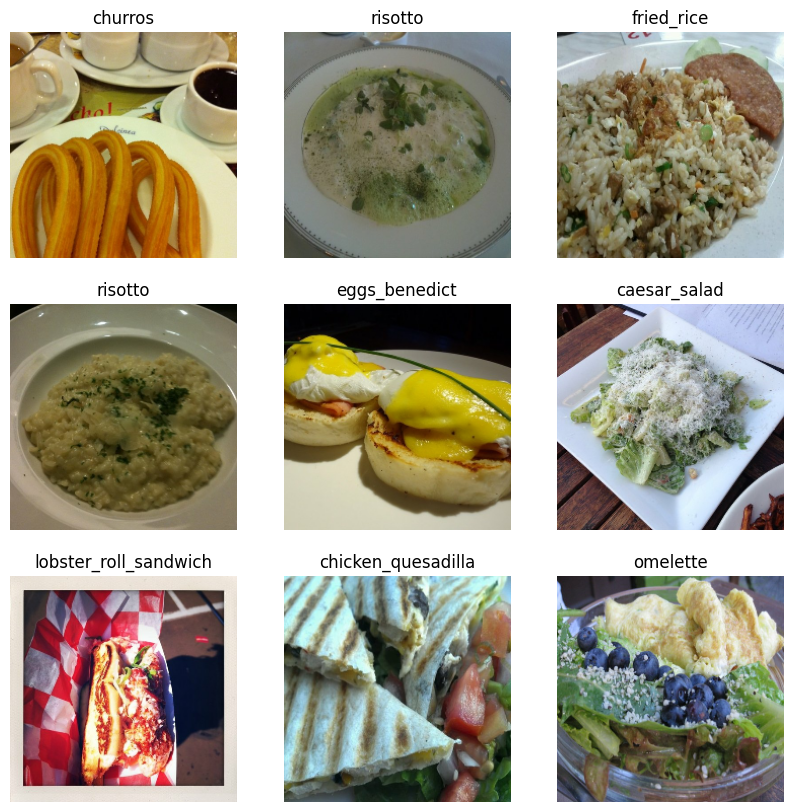

In [ ]:
#Step 6
for images, labels in ds_train.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        label = ds_info.features['label'].int2str(labels[i].numpy())
        plt.title(label)
        plt.axis("off")

    plt.show()


In [ ]:
#step-7
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze base layers

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  # Flatten feature maps
    tf.keras.layers.Dense(181, activation='softmax')  # 181 food categories
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(ds_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
# Unfreeze some layers of the base model
for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training for a few more epochs
history_fine_tune = model.fit(ds_train, epochs=5, validation_data=ds_test)

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save('food_classification_model.h5')

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('food_classification_model.h5')

# Preprocess the new image
new_image = ...  # Load and preprocess the image
new_image = np.expand_dims(new_image, axis=0)  # Add batch dimension

# Make prediction
prediction = model.predict(new_image)
predicted_class = np.argmax(prediction)

# Get the class label
class_label = ds_info.features['label'].int2str(predicted_class)
print("Predicted Class:", class_label)